<a href="https://colab.research.google.com/github/ihsan292292/HandWrittenTextExtraction/blob/main/extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/TCSion/words.zip" "words.zip"
!cp "/content/drive/MyDrive/TCSion/words.txt" "words.txt"
!unzip 'words.zip'

Streaming output truncated to the last 5000 lines.
 extracting: words/a01-020-04-04.png  
 extracting: words/d07-085-01-00.png  
 extracting: words/k02-023-00-05.png  
 extracting: words/b06-019-05-04.png  
 extracting: words/g06-047p-05-05.png  
 extracting: words/g01-074-07-02.png  
 extracting: words/g06-011b-06-02.png  
 extracting: words/g04-095-03-01.png  
 extracting: words/r02-054-01-03.png  
 extracting: words/j01-045-09-04.png  
 extracting: words/a01-113u-09-04.png  
 extracting: words/b03-098-05-02.png  
 extracting: words/b01-049-01-04.png  
 extracting: words/d04-066-00-07.png  
 extracting: words/p03-047-00-09.png  
 extracting: words/h02-008-05-03.png  
 extracting: words/b02-013-05-06.png  
 extracting: words/k02-117-06-00.png  
 extracting: words/d01-104-01-03.png  
 extracting: words/d07-089-06-06.png  
 extracting: words/c03-007a-03-02.png  
 extracting: words/a02-037-08-07.png  
 extracting: words/p02-139-02-05.png  
 extracting: words/f02-076-05-05.png  
 extracti

In [ ]:
import cv2
import os
import numpy as np

## Reading words.txt and random sampling 15000 words that does not have errors

In [ ]:
with open('words.txt') as f:
    contents = f.readlines()
f.close()

In [ ]:
def clean(text):
    temp = text.rstrip("\n").split(' ')
    return temp[0] + ' ' + " ".join(temp[8:])

In [ ]:
img_files = [f.split('.png')[0] for f in os.listdir('words')]
file_list = [clean(f) for f in contents[18:] if f.split(' ')[1] == 'ok']
file_list = [itm for itm in file_list if itm.split(' ')[0] in img_files]

In [ ]:
len(img_files)

90000

In [ ]:
file_names = [itm.split(' ')[0] for itm in file_list]
labels = [' '.join(itm.split(' ')[1:]) for itm in file_list]

In [ ]:
len(labels)

90000

In [ ]:
char_set = set()
for word in labels:
    for char in word:
        char_set.add(char)

char_set.remove(' ')
char_list = sorted(list(char_set))

In [ ]:
for word in labels:
    if word.count(' ') > 0:
        print(word)

M P
0M Ps
0M P
M Ps
M Ps
M Ps
M Ps
0M Ps
M Ps
M Ps
M Ps
M Ps
M Ps
B B C
T V
B B C
B B C
I T V
T V
C O
B B C's
T V
n log n


In [ ]:
max_label_len = 0

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
    return dig_lst

def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)
    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255
    return img

In [ ]:
max_label_len = 0
all_images = []
all_labels = []
all_input_length = []
label_length = []
original_text = []

for line in file_list:
    splits = line.split(' ')
    file_name = splits[0]
    word = ' '.join(splits[1:])
    img = cv2.imread('words/{}.png'.format(file_name), cv2.IMREAD_GRAYSCALE)
    #print(img)
    try:
        img = process_image(img)
        label = encode_to_labels(word)
        #print(label)
    except:
        print(f"[{word}]")
        continue
    all_images.append(img)
    all_labels.append(label)
    all_input_length.append(31)
    label_length.append(len(word))
    original_text.append(word)

    if len(word) > max_label_len:
        max_label_len = len(word)

[M P]
[0M Ps]
[0M P]
[M Ps]
[M Ps]
[M Ps]
[M Ps]
[0M Ps]
[M Ps]
[M Ps]
[M Ps]
[Powell]
[M Ps]
[M Ps]
[B B C]
[T V]
[B B C]
[B B C]
[I T V]
[T V]
[C O]
[B B C's]
[T V]
[n log n]
[more]


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
padded_labels = pad_sequences(all_labels, maxlen=max_label_len, padding='post')
padded_labels = np.asarray(padded_labels)

In [ ]:
train_size = 0.85

split_index = int(len(all_images) * 0.85)
train_images = np.array(all_images[:split_index])
valid_images = np.array(all_images[split_index:])

train_padded_label = np.array(padded_labels[:split_index])
valid_padded_label = np.array(padded_labels[split_index:])

train_input_length = np.array(all_input_length[:split_index])
valid_input_length = np.array(all_input_length[split_index:])

train_label_length = np.array(label_length[:split_index])
valid_label_length = np.array(label_length[split_index:])

train_original_text = np.array(original_text[:split_index])
valid_original_text = np.array(original_text[split_index:])

In [ ]:
train_padded_label.shape, valid_padded_label.shape, max_label_len

((76478, 21), (13497, 21), 21)

In [ ]:
train_images.shape, valid_images.shape, train_input_length.shape, valid_input_length.shape, train_label_length.shape, valid_label_length.shape, train_original_text.shape, valid_original_text.shape

((76478, 32, 128, 1),
 (13497, 32, 128, 1),
 (76478,),
 (13497,),
 (76478,),
 (13497,),
 (76478,),
 (13497,))

###Model building

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Bidirectional, LSTM, MaxPool2D, Input, Lambda
#from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=256
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int8')
label_length = Input(name='label_length', shape=[1], dtype='int8')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 8
epochs = 35
e = str(epochs)
optimizer = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics=['accuracy'])

filepath="weights.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
with open('model.json', 'w') as f:
    f.write(model.to_json())
f.close()

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/35

Epoch 1: val_accuracy improved from -inf to 0.31044, saving model to weights.hdf5
9560/9560 - 287s - loss: 7.8332 - accuracy: 0.1527 - val_loss: 3.5558 - val_accuracy: 0.3104 - 287s/epoch - 30ms/step
Epoch 2/35

Epoch 2: val_accuracy improved from 0.31044 to 0.48329, saving model to weights.hdf5
9560/9560 - 263s - loss: 2.7177 - accuracy: 0.4143 - val_loss: 2.3705 - val_accuracy: 0.4833 - 263s/epoch - 27ms/step
Epoch 3/35

Epoch 3: val_accuracy improved from 0.48329 to 0.53953, saving model to weights.hdf5
9560/9560 - 282s - loss: 1.8860 - accuracy: 0.5307 - val_loss: 1.9594 - val_accuracy: 0.5395 - 282s/epoch - 30ms/step
Epoch 4/35

Epoch 4: val_accuracy improved from 0.53953 to 0.60517, saving model to weights.hdf5
9560/9560 - 285s - loss: 1.4588 - accuracy: 0.6029 - val_loss: 1.6616 - val_accuracy: 0.6052 - 285s/epoch - 30ms/step
Epoch 5/35

Epoch 5: val_accuracy improved from 0.60517 to 0.61799, saving model to weights.hdf5
9560/9560 - 283s - loss: 1.1591 - accuracy: 0.

In [ ]:
!cp "weights.hdf5" "/content/drive/MyDrive/TCSion/weights.hdf5"
!cp "model.json" "/content/drive/MyDrive/TCSion//model.json"

act_model.load_weights(filepath)
act_model.save("full_model.h5")
!cp "full_model.h5" "/content/drive/MyDrive/TCSion/full_model.h5"

###Testing

In [ ]:
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)

422/422 [==============================] - 9s 14ms/step


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from keras.models import load_model

saved_model = load_model("full_model.h5")

In [ ]:
def predict_image(index):
    pred = saved_model.predict(np.expand_dims(valid_images[index], axis=0))
    out = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0])
    letters = ''
    for x in out[0]:
        if int(x) != -1:
            letters += char_list[int(x)]
    return letters, valid_original_text[index]

1/1 [==============================] - 2s 2s/step


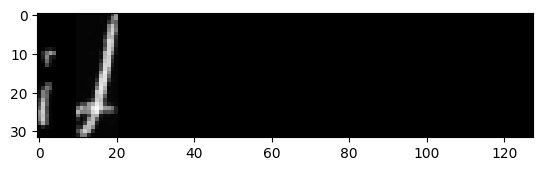

it it
1/1 [==============================] - 0s 23ms/step


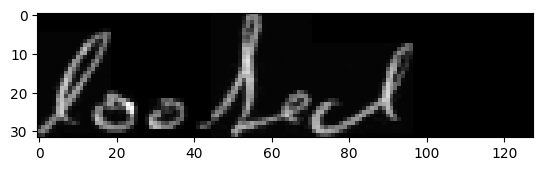

looked looked
1/1 [==============================] - 0s 27ms/step


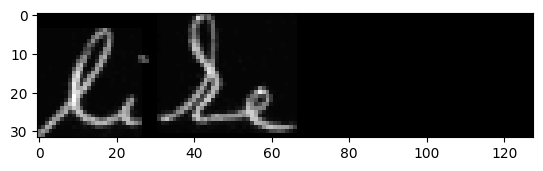

like like
1/1 [==============================] - 0s 37ms/step


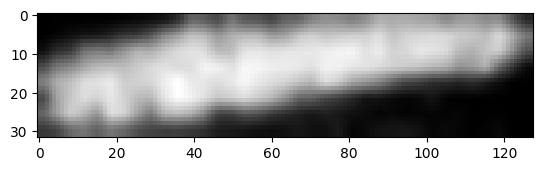

- -
1/1 [==============================] - 0s 26ms/step


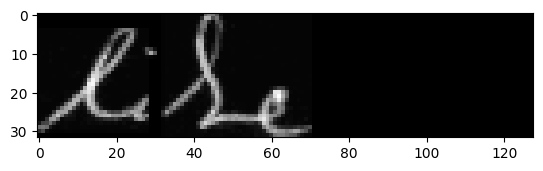

like like
1/1 [==============================] - 0s 35ms/step


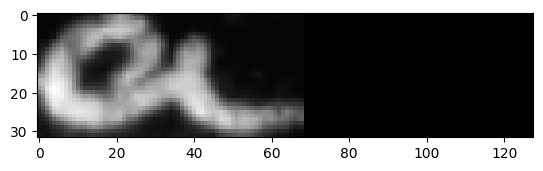

a a
1/1 [==============================] - 0s 23ms/step


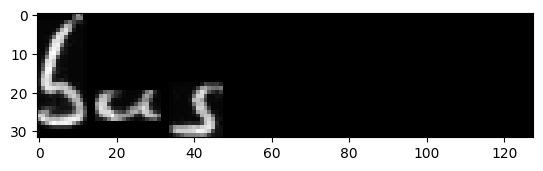

bus bus
1/1 [==============================] - 0s 26ms/step


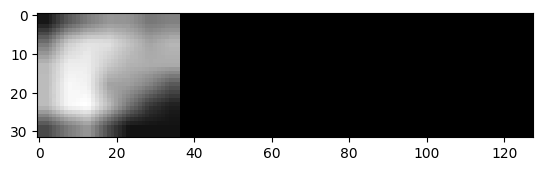

. .
1/1 [==============================] - 0s 27ms/step


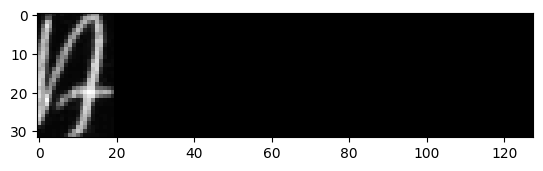

It A
1/1 [==============================] - 0s 28ms/step


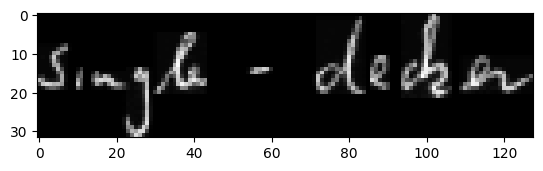

single-dechon single-decker


In [ ]:
for i in range(10):
    predicted_text, original_text = predict_image(i)
    plt.imshow(valid_images[i], cmap=plt.cm.gray)
    plt.show()
    print(predicted_text, original_text)

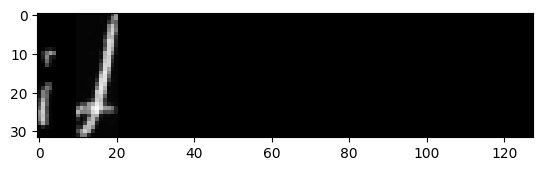

In [ ]:
plt.imshow(valid_images[0], cmap=plt.cm.gray)

In [ ]:
pred = saved_model.predict(np.expand_dims(valid_images[0], axis=0))
out = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0])
out

1/1 [==============================] - 0s 43ms/step


array([[60, 71, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])